# Dự Đoán Đột Quỵ Bằng Thuật Toán KNN (K-nearest neighbors)


# Cài đặt thư viện

In [3]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter


# !pip install missingno
# !pip install  pandas_profiling
# visulaization modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots
# import pandas_profiling as pp
# !pip install pywaffle

%matplotlib inline
init_notebook_mode(connected= True)
# !pip install mlxtend

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import classification_report ,f1_score,precision_score,recall_score,roc_auc_score
from mlxtend.plotting import plot_confusion_matrix


# Đọc dataset

In [4]:
data=pd.read_csv("./brain_stroke.csv")

### `Brain Stroke Classifier`

* Attribute Information
    - gender: "Male", "Female" or "Other"
    - age: age of the patient
    - hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
    - heart disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease 5) ever-married: "No" or "Yes"
    - worktype: "children", "Govtjov", "Neverworked", "Private" or "Self-employed" 7) Residencetype: "Rural" or "Urban"
    - avgglucoselevel: average glucose level in blood
    - bmi: body mass index
    - smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
    - stroke: 1 if the patient had a stroke or 0 if not
    
More Information
* For BMI levels:
    - below 18.5 : you're in the underweight range
    - between 18.5 and 24.9 : you're in the healthy weight range
    - between 25 and 29.9 : you're in the overweight range
    - between 30 and 39.9 : you're in the obese range
* For glucose levels:
    - A fasting blood sugar level of 99 mg/dL or lower is normal
    - 100 to 125 mg/dL indicates you have prediabetes
    - 126 mg/dL or higher indicates you have diabetes

# Phân tích dữ liệu

## Tổng quan về bộ dữ liệu

In [5]:
# Số feature của bộ dữ liệu
print(f"We have {len(data.columns)} columns")
print(f"Include: ",data.columns.to_list())

We have 11 columns
Include:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [6]:
data.head(5) #Xem 5 dòng đầu của dữ liệu

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


## Tiền xử lý dữ liệu

In [7]:
cols_need_replace=["hypertension","heart_disease","stroke"] 
#Chọn các feature có dữ liệu 1 hoặc 0

In [8]:
for col in cols_need_replace:
    data[col]=data[col].replace({0:"No",1:"Yes"}) # chuyển 0 thành "No" và 1 thành "yes":
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,Yes
1,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes
2,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,Yes
3,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,Yes
4,Male,81.0,No,No,Yes,Private,Urban,186.21,29.0,formerly smoked,Yes


In [9]:
print("Thống kê Categorical Data")
data.describe(exclude=np.number)

Thống kê Categorical Data


,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,4981,4981,4981,4981,4981,4981,4981,4981
unique,2,2,2,2,4,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,No
freq,2907,4502,4706,3280,2860,2532,1838,4733


In [10]:
print("Thống kê numerical_features")
data.describe(include=np.number)

Thống kê numerical_features


,age,avg_glucose_level,bmi
count,4981.000000,4981.000000,4981.000000
mean,43.419859,105.943562,28.498173
std,22.662755,45.075373,6.790464
min,0.080000,55.120000,14.000000
25%,25.000000,77.230000,23.700000
50%,45.000000,91.850000,28.100000
75%,61.000000,113.860000,32.600000
max,82.000000,271.740000,48.900000


## Kiểm tra bộ dữ liệu rỗng (NULL) trong 4981 sample

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   object 
 3   heart_disease      4981 non-null   object 
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   object 
dtypes: float64(3), object(8)
memory usage: 428.2+ KB


This dataset have not null values

## Kiểm tra bộ dữ liệu trùng

In [12]:

data[data.duplicated()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


## Khai phá dữ liệu

In [13]:
target_feature="stroke" #Lưu label (Nhãn)

In [14]:
df=data.copy() #Tạo bản sao cho dữ liệu ban đầu

In [15]:
categorical_col=[col for col in df.select_dtypes(include=["object"]).columns.to_list() if col !=target_feature] 
#Chọn ra các cột dữ liệu categorical trừ label

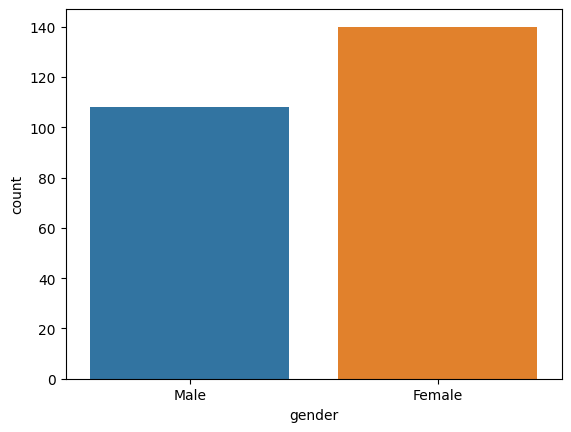

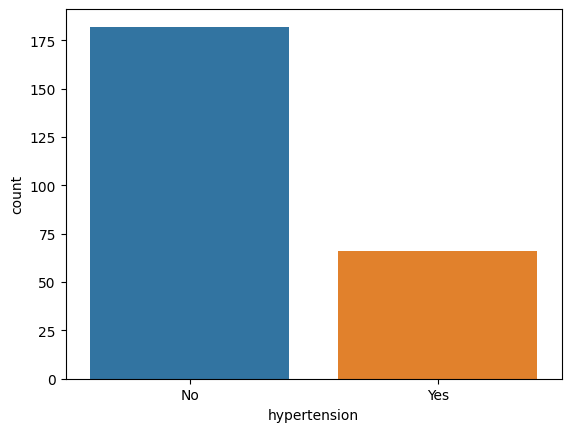

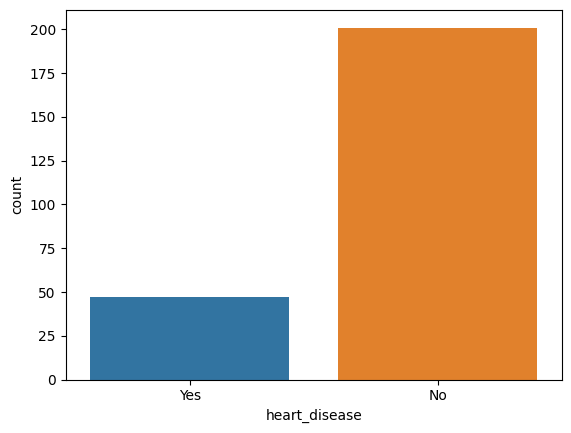

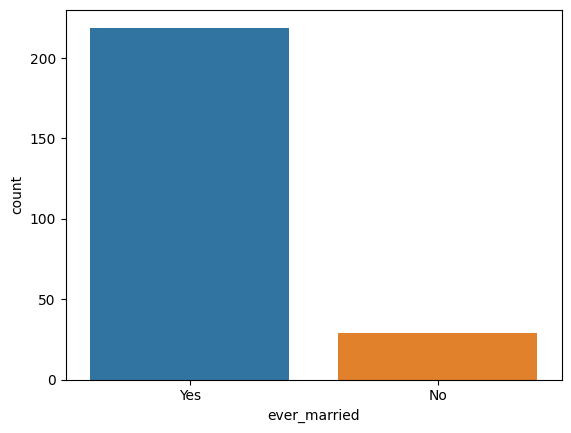

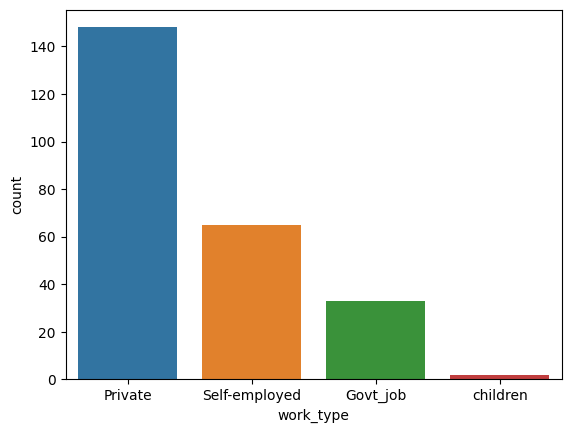

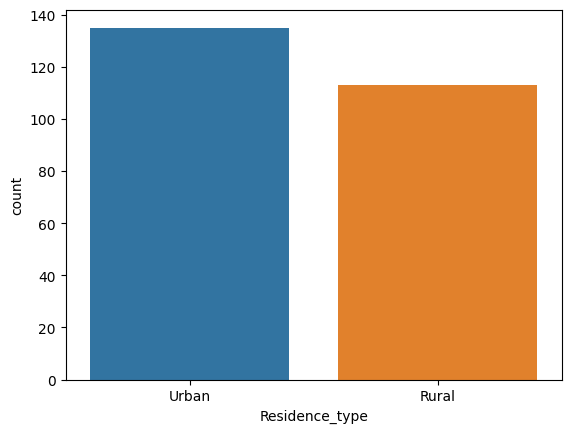

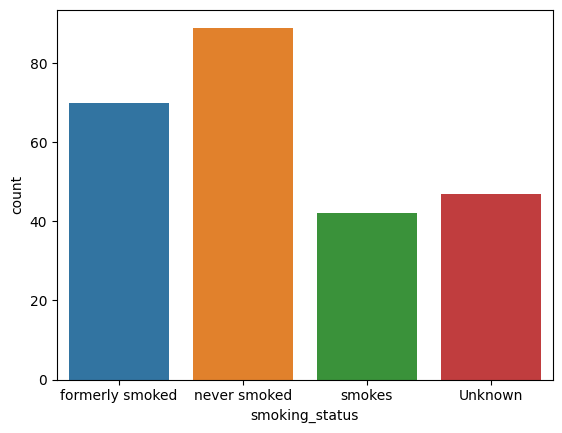

In [16]:
for col in categorical_col:
    sns.countplot(data=df[df["stroke"]=="Yes"],x=col)
    plt.show() #In ra biểu đồ các cột dữ liệu categorical theo label

In [17]:
numerical_cols=df.select_dtypes(include=np.number).columns.to_list()  #Lấy ra các bộ dữ liệu dạng Numberical

Kiểm tra dữ liệu ngoại lệ

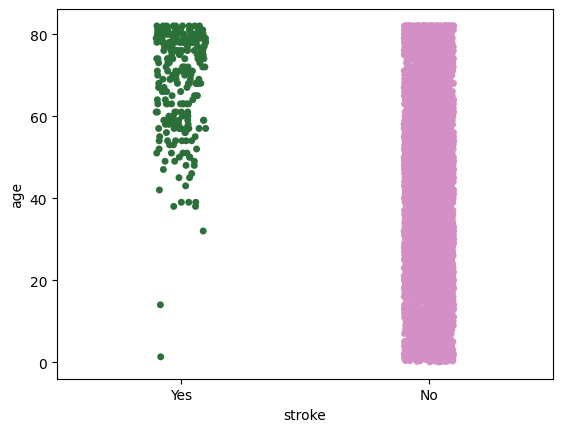

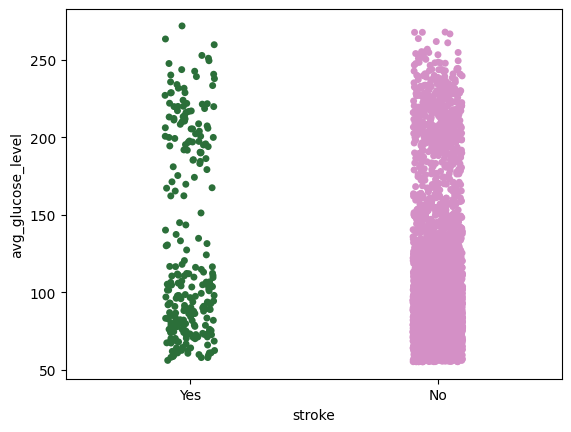

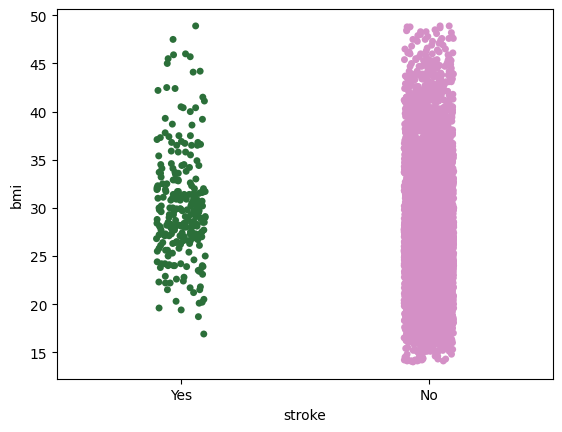

In [18]:
for col in numerical_cols:
    sns.stripplot(y=col, x ="stroke", data = data, palette='cubehelix')
    plt.show()

# Xử Lý Dữ Liệu

## Encoding categorical features

In [19]:
categorical_cols=df.select_dtypes(include=["object"]).columns.to_list()


In [20]:
categorical_cols

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'stroke']

In [21]:
binary_encoder_cols=[col for col in categorical_cols if len(df[col].unique())==2]

In [22]:
# Processing features has 2 values
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
for col in binary_encoder_cols:
    df[col]=lb.fit_transform(df[col])

In [23]:
# Processing features has more 2 values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in categorical_cols:
    if col not in binary_encoder_cols:
        df[col]=le.fit_transform(df[col])

In [24]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1
1,1,80.0,0,1,1,1,0,105.92,32.5,2,1
2,0,49.0,0,0,1,1,1,171.23,34.4,3,1
3,0,79.0,1,0,1,2,0,174.12,24.0,2,1
4,1,81.0,0,0,1,1,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,1,41.0,0,0,0,1,0,70.15,29.8,1,0
4977,1,40.0,0,0,1,1,1,191.15,31.1,3,0
4978,0,45.0,1,0,1,0,0,95.02,31.8,3,0
4979,1,40.0,0,0,1,1,0,83.94,30.0,3,0


## Lượt bỏ các feature ít quan trọng

<AxesSubplot: >

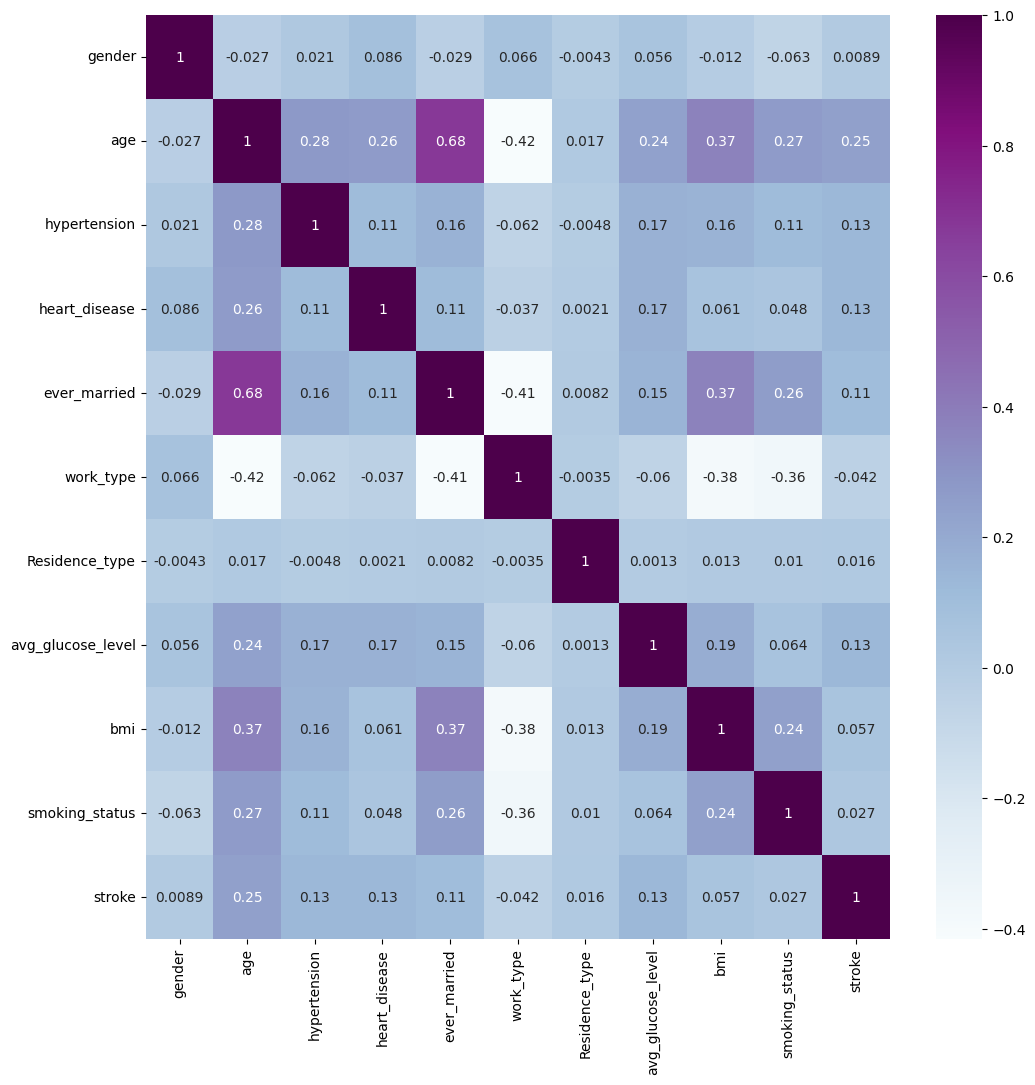

In [25]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,cmap="BuPu")

In [26]:
feature_selection=[col for col,value in df.corr()["stroke"].items() if value>0.05]
#Lấy ra các feature có độ ảnh hưởng lơn 0.05
final_data=df[feature_selection] #Lưu lại dữ liệu đã xử lý
final_data #Dữ liệu chuẩn bị train

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
0,67.0,0,1,1,228.69,36.6,1
1,80.0,0,1,1,105.92,32.5,1
2,49.0,0,0,1,171.23,34.4,1
3,79.0,1,0,1,174.12,24.0,1
4,81.0,0,0,1,186.21,29.0,1
...,...,...,...,...,...,...,...
4976,41.0,0,0,0,70.15,29.8,0
4977,40.0,0,0,1,191.15,31.1,0
4978,45.0,1,0,1,95.02,31.8,0
4979,40.0,0,0,1,83.94,30.0,0


## Xử lý dữ liệu không cân bằng

In [27]:
fig=px.pie(final_data,values=df[target_feature].value_counts(),
           names=["No stroke","stroke"],title="<b>Biểu đồ tương quan người bị bệnh và không bị bệnh",
           hole=.5,
       color_discrete_sequence=px.colors.qualitative.Pastel,template="plotly")
fig.update_layout(title_font_size=20)
fig.show()

In [28]:
data_us = final_data.copy()
X=data_us.drop(columns=target_feature,axis=1) #Bỏ label ra khỏi dữ liệu cần xử lý
y=data_us["stroke"] #Chuyển lable vào biến y

In [29]:
#In ra kết quả để kiểm tra
print(X)
print(y)

       age  hypertension  heart_disease  ever_married  avg_glucose_level   bmi
0     67.0             0              1             1             228.69  36.6
1     80.0             0              1             1             105.92  32.5
2     49.0             0              0             1             171.23  34.4
3     79.0             1              0             1             174.12  24.0
4     81.0             0              0             1             186.21  29.0
...    ...           ...            ...           ...                ...   ...
4976  41.0             0              0             0              70.15  29.8
4977  40.0             0              0             1             191.15  31.1
4978  45.0             1              0             1              95.02  31.8
4979  40.0             0              0             1              83.94  30.0
4980  80.0             1              0             1              83.75  29.1

[4981 rows x 6 columns]
0       1
1       1
2      

Chuẩn hóa dữ liệu (Scaling)

In [30]:
#Thay đổi khoảng giá trị dữ liệu
def standarding_numerical(df,numerical_cols):
    from sklearn.preprocessing import StandardScaler
    sc=StandardScaler()
    dict_cs={}
    for col in numerical_cols:
        sc=sc.fit(df[[col]])
        # df[col]=sc.transform(df[[col]])
        dict_cs[col]=sc
    return dict_cs

In [31]:
# from sklearn.preprocessing import StandardScaler
dict_sc=standarding_numerical(X,numerical_cols)
for col in numerical_cols:
    X[[col]]=dict_sc[col].transform(X[[col]])
X #In ra kiểm tra
    

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,5.670554,0,1,1,29.484279,1.193238
1,7.585196,0,1,1,11.402697,0.589390
2,3.019512,0,0,1,21.021563,0.869222
3,7.437916,1,0,1,21.447202,-0.662492
4,7.732476,0,0,1,23.227819,0.073909
...,...,...,...,...,...,...
4976,1.841271,0,0,0,6.134487,0.191733
4977,1.693991,0,0,1,23.955383,0.383197
4978,2.430391,1,0,1,9.797344,0.486294
4979,1.693991,0,0,1,8.165480,0.221189


### Under sampling

In [31]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X_us, y_us= nm1.fit_resample(X, y) #Lưu dữ liệu đã xử lý under sampling vào X_us và y_us
print(sorted(Counter(y_us).items()))
print(X_us)
print(y_us)

[(0, 248), (1, 248)]
          age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0    7.437916             1              0             1           6.701515   
1    6.848795             0              0             1          11.359986   
2    7.585196             0              0             1           6.685314   
3    4.345033             0              0             1           8.312760   
4    7.585196             0              0             1           6.496796   
..        ...           ...            ...           ...                ...   
491  7.437916             0              0             1          12.706126   
492  6.701515             0              0             1          20.417714   
493  6.996075             1              1             1          25.238193   
494  6.701515             0              0             1           4.783928   
495  6.259675             1              0             1           8.733981   

          bmi  
0    0.162277 

In [32]:
from sklearn.model_selection import train_test_split
#Chia 80% tập train 20% tập test
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size = 0.2, random_state = 0)
print("Kết quả chia tập train và test : ")
print(X_train_us.shape)
print(y_train_us.shape)
print(X_test_us.shape)
print(y_test_us.shape)

Kết quả chia tập train và test : 
(396, 6)
(396,)
(100, 6)
(100,)


### Xử lý Over sampling

In [32]:
#Dùng Smote đễ xử lý Over Sampling
from imblearn.over_sampling import SMOTE
model_SMOTE = SMOTE(random_state = 156)
X_os_smote, y_os_smote = model_SMOTE.fit_resample(X, y)
X_os_smote #In dữ liệu


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi
0,5.670554,0,1,1,29.484279,1.193238
1,7.585196,0,1,1,11.402697,0.589390
2,3.019512,0,0,1,21.021563,0.869222
3,7.437916,1,0,1,21.447202,-0.662492
4,7.732476,0,0,1,23.227819,0.073909
...,...,...,...,...,...,...
9461,5.516197,0,0,1,6.319999,0.064135
9462,3.938426,1,0,1,7.213486,-0.021234
9463,6.060548,0,0,1,31.298742,2.423669
9464,7.696631,0,1,1,26.834668,0.326911


In [34]:
from sklearn.model_selection import train_test_split
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os_smote, y_os_smote, 
                                                                test_size = 0.2, random_state = 0)
print("Kiểm tra kết quả xử lý: ")
print(X_train_os.shape)
print(y_train_os.shape)
print(X_test_os.shape)
print(y_test_os.shape)

Kiểm tra kết quả xử lý: 
(7572, 6)
(7572,)
(1894, 6)
(1894,)


## Hàm vẽ confusion matrix của kết quả dự đoán 

In [35]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def ConfusionMatrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print(classification_report(y_test, y_pred))
    
    fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
def evalate_model(model,X_test,y_test):
    X_test_us_norm=X_test.copy()
    # dict_sc_os=standarding_numerical(X_train,numerical_cols)
    # for col in numerical_cols:
    # # X_train_os[[col]]=dict_sc_os[col].transform(X_train_os[[col]])
    #     X_test_us_norm[[col]]=dict_sc_os[col].transform(X_test_us_norm[[col]])
    y_pred = model.predict(X_test_us_norm)
    ConfusionMatrix(y_test, y_pred)


# Train và dự đoán kết quả

# Oversampling

[[708 236]
 [ 25 925]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.84       944
           1       0.80      0.97      0.88       950

    accuracy                           0.86      1894
   macro avg       0.88      0.86      0.86      1894
weighted avg       0.88      0.86      0.86      1894



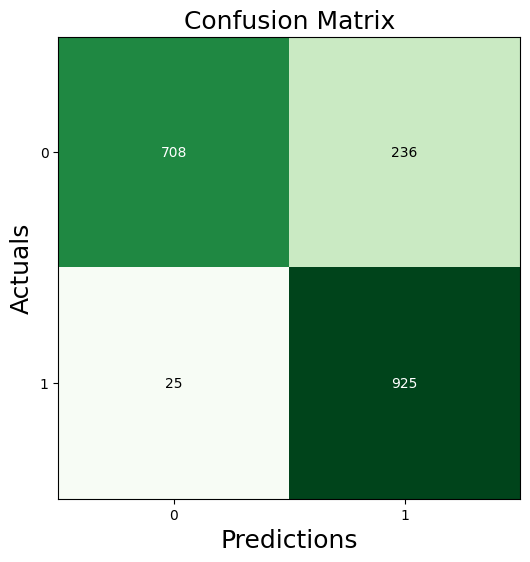

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn_model=KNeighborsClassifier(n_neighbors=20,weights="distance",algorithm="auto",metric="minkowski")
knn_model.fit(X_train_os,y_train_os)
evalate_model(knn_model,X_test_os,y_test_os)

In [83]:
# Model Deployment (Model Saved and Load)
import dill
filename = "knn_model.dill"
with open(filename, "wb") as f:
    dill.dump(knn_model, f)
    print(f"Lưu model thành công")

Lưu model thành công


[[46  3]
 [25 26]]
              precision    recall  f1-score   support

           0       0.65      0.94      0.77        49
           1       0.90      0.51      0.65        51

    accuracy                           0.72       100
   macro avg       0.77      0.72      0.71       100
weighted avg       0.77      0.72      0.71       100



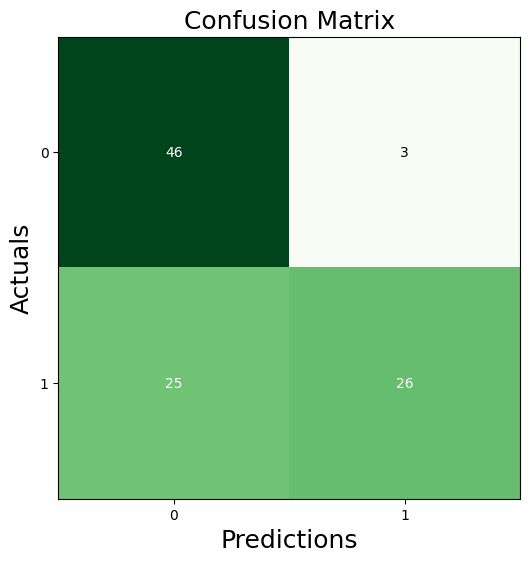

In [38]:
knn_model_u=KNeighborsClassifier(n_neighbors=20,weights="distance",algorithm="auto",metric="minkowski")
knn_model_u.fit(X_train_us,y_train_us)
evalate_model(knn_model_u,X_test_us,y_test_us)

# Kết thúc quá trình
    